In [1]:
import carla
import math
import random
import time
import matplotlib.pyplot as plt

client=carla.Client('localhost',2000)
world=client.get_world()
world = client.load_world('Town04')

#leader spawn locations
x=-400.31317901611328
y=9.332647323608398
z= 0.934486389160156

#Follower distances
d1=9
d2=15


In [4]:
bp_lib=world.get_blueprint_library()


location=carla.Location(x,y,z)
rotation=carla.Rotation(pitch=0,yaw=0,roll=0)
transform=carla.Transform(location,rotation)

location2=carla.Location(x-d1,y,z)
rotation2=carla.Rotation(pitch=0,yaw=0,roll=0)
transform2=carla.Transform(location2,rotation2)

location3=carla.Location(x-d1-d2,y,z)
rotation3=carla.Rotation(pitch=0,yaw=0,roll=0)
transform3=carla.Transform(location3,rotation3)

vehicle_bp1=bp_lib.find('vehicle.lincoln.mkz_2020')
vehicle_bp2=bp_lib.find('vehicle.lincoln.mkz_2020')
vehicle_bp3=bp_lib.find('vehicle.lincoln.mkz_2020')

vehicle=world.try_spawn_actor(vehicle_bp1,transform)
vehicle2=world.try_spawn_actor(vehicle_bp2,transform2)
vehicle3=world.try_spawn_actor(vehicle_bp3,transform3)

vehicles=[vehicle,vehicle2,vehicle3]

n=len(vehicles)-1

acc=[0]*(n+1)
brake=[0]*(n+1)
steering=[0]*(n+1)

y_init=[y,y,y]
x_init=[x,x-d1,x-d1-d2]
yaw_init=[0,0,0]

'\nfor i in range(0,3):\n    vehicle=vehicles[i]\n    print(i,vehicle)\n    x_init.append(vehicle.get_transform().location.x)\n    print(vehicle.get_transform())\n    y_init.append(vehicle.get_transform().location.y)\n    yaw_init.append(vehicle.get_transform().rotation.yaw)\n\n'

In [ ]:
# Find the blueprint of the sensor.
cam_blueprint =bp_lib.find('sensor.camera.rgb')
# Modify the attributes of the blueprint to set image resolution and field of view.
cam_blueprint.set_attribute('image_size_x', '1920')
cam_blueprint.set_attribute('image_size_y', '1080')
cam_blueprint.set_attribute('fov', '110')
# Set the time in seconds between sensor captures
cam_blueprint.set_attribute('sensor_tick', '1.0')

cam_transform = carla.Transform(carla.Location(x=x, y=y, z=z))
cam_sensor = world.spawn_actor(cam_blueprint, cam_transform, attach_to=vehicle)

# do_something() will be called each time a new image is generated by the camera.
sensor.listen(lambda data: do_something(data))

In [5]:
def saturate(x):
    if x>1:
        return 1
    elif x<-1:
        return -1
    else:
        return x

In [6]:
n=len(vehicles)-1
DY=[]
DX=[]
Theta=[]
prev_theta=[]
Ed=[]
Dyaw=[]
dyaw_prev=[0]*n

for i in range(n):
    DY.append([])
    DX.append([])
    Theta.append([])
    Ed.append([])
    Dyaw.append([])
    
    
DY.append([])
DX.append([])
Theta.append([])    
T=[]

In [7]:
def leader_lane_change_right():
    
    global vehicles,steering,acc,y_init,yaw_init,y_curr,lane_change_finish,kp,kp2
    
    leader=vehicles[0]
    
    dy=leader.get_transform().location.y-y_curr
    ey=4-dy
    eyaw=(leader.get_transform().rotation.yaw-yaw_init[0])*(math.pi/180)
    
    if(dy<=2):
        s=kp2*(ey-2)
        a=0.2
    elif(abs(ey) > 0.1 or abs(eyaw)>0.05):
        s=-kp*(eyaw)+kp2*(ey)
        a=0.2
    else:
        s=-kp*(eyaw)
        a=0.5
        lane_change_finish=True
    steering[0]=s
    acc[0]=a
    
    leader.apply_control(carla.VehicleControl(a,s,0))

In [8]:
def leader_lane_change_left():
    
    global vehicles,steering,acc,y_init,yaw_init,y_curr,lane_change_finish,kp,kp2
    
    leader=vehicles[0]
    
    dy=leader.get_transform().location.y-y_curr
    ey=-4-dy
    eyaw=(leader.get_transform().rotation.yaw-yaw_init[0])*(math.pi/180)
    
    if(dy>=-2):
        s=kp2*(ey+2)
        a=0.2
    elif(abs(ey) >0.1 or abs(eyaw)>0.05):
        s=-kp*(eyaw)+kp2*(ey)
        a=0.2
    else:
        a=0.5
        s=-kp*(eyaw)
        lane_change_finish=True
    
    steering[0]=s
    acc[0]=a
    leader.apply_control(carla.VehicleControl(a,s,0))

In [9]:
def longitudinal_and_orientation_control():
    
    global vehicles,steering,acc,brake,yaw_init,lane_change_finish,kp,kp_o,kp_y,kp_exp,ddef,tgap,Ed,Dyaw,dyaw_prev
    
    leader=vehicles[0]
    
    if(lane_change_finish):
        eyaw=leader.get_transform().rotation.yaw - yaw_init[0]
        a=0.5
        s=-kp*(eyaw)/10
        steering[0]=s
    
    leader.apply_control(carla.VehicleControl(acc[0],steering[0],brake[0]))
    
    for i in range(1,len(vehicles)):
        follower=vehicles[i]
        theta=follower.get_transform().rotation.yaw

        #Orientation Control
        dyaw=(leader.get_transform().rotation.yaw - follower.get_transform().rotation.yaw)*(math.pi)/180
        d_dyaw= dyaw - dyaw_prev[i-1]
        
        ey=leader.get_transform().location.y-follower.get_transform().location.y
        
        #steering[i]=0.4*steering[i-1] + kp_o*(dyaw)  +  kp_y*ey*e**(-kp_exp*ey)
        steering[i]=0.4*steering[0] + kp_o*(dyaw)+ kd_y*d_dyaw/dt  +  kp_y*ey*abs(ey)   #*e**(abs(kp_exp*ey))
        #Longitudinal Control
        dx_= vehicles[i-1].get_transform().location.x-vehicles[i].get_transform().location.x
        dy_= vehicles[i-1].get_transform().location.y-vehicles[i].get_transform().location.y
        
        drel=math.sqrt(dx_**2 + dy_**2)
       

        vx=follower.get_velocity().x
        vy=follower.get_velocity().y
       

        v=math.sqrt(vx**2+vy**2)
       
        
        alpha=math.atan2(dy_,dx_)
        theta=(vehicles[i].get_transform().rotation.yaw)*(math.pi/180)

        lambda_=alpha-theta
    
        dsafe = ddef + (tgap*v*math.cos(lambda_))
    
        ed=drel-dsafe
        
        Ed[i-1].append(ed)
        Dyaw[i-1].append(dyaw)
        dyaw_prev[i-1]=dyaw
        
        t=saturate(kp_d*ed)

        if (t>=0):
            acc[i]=t
            brake[i]=0
        else:
            brake[i] = abs(t)
            acc[i]=0
        
        vehicles[i].apply_control(carla.VehicleControl(acc[i],steering[i],brake[i]))


In [11]:
#steering control

ddef=10
tgap=1

#longitudinal control
kp_d=1

#lane change for lead vehicle
kp=1.2
kp2=0.2

#orientation control for followers
kp_o=0.5
kp_y=1 #0.5 #0.2 #0.08 #0.05
kd_y=0.2
kp_exp= 4   #0.5 #1 #2 #4
dt=0.01

e=math.e
is_lane_change=False
lane_change_finish=True
acc[0]=.5

for i in range(0,len(vehicles)):
    vehicle=vehicles[i]
    vehicle.apply_control(carla.VehicleControl(acc[i],steering[i],brake[i]))


t=time.time()
while (time.time()-t <70):
    
    spectator=world.get_spectator()
    transform_d=carla.Transform(vehicles[-1].get_transform().location + carla.Location(x=-35,z=15),carla.Rotation(yaw=0))
    spectator.set_transform(transform_d)

    
    ts=time.time()-t
    T.append(ts)
    leader=vehicles[0]
    if(time.time()-t >20):
        
        
        if not is_lane_change:
            y_curr=leader.get_transform().location.y
            is_lane_change=True
            lane_change_finish=False
            
        if not lane_change_finish:
            leader_lane_change_left()
            #leader_lane_change_right()
        
    longitudinal_and_orientation_control()
    
    for i in range(0,len(vehicles)):
        vehicle=vehicles[i]
        DX[i].append(vehicle.get_transform().location.x-x_init[i])
        DY[i].append(vehicle.get_transform().location.y-y_init[i])
        Theta[i].append((vehicle.get_transform().rotation.yaw-yaw_init[i])*math.pi/180)
    
  

RuntimeError: time-out of 5000ms while waiting for the simulator, make sure the simulator is ready and connected to localhost:2000

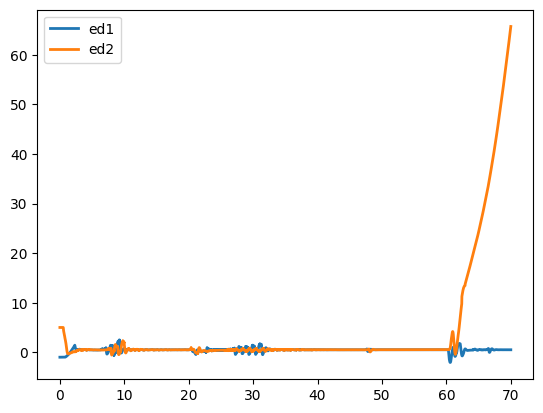

In [10]:
fig, ax = plt.subplots()
import numpy as np
Ed=np.array(Ed).T
ax.plot(T, Ed, linewidth=2.0)
plt.legend(["ed1","ed2","ed3"], loc ="upper left")
plt.show()

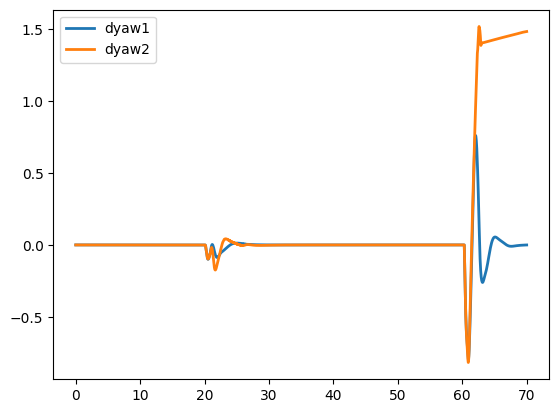

In [11]:
fig, ax = plt.subplots()
Dyaw=np.array(Dyaw).T
ax.plot(T, Dyaw, linewidth=2.0)
plt.legend(["dyaw1","dyaw2","dyaw3"], loc ="upper left")
plt.show()

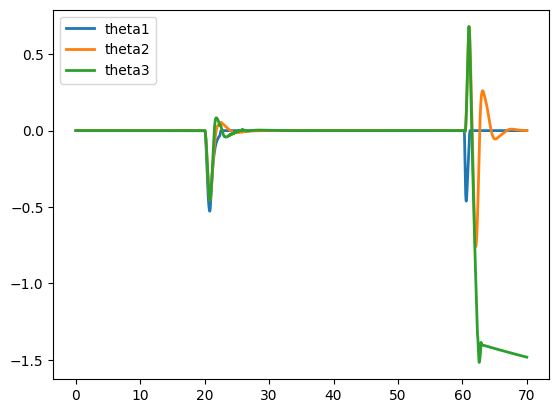

In [12]:
fig, ax = plt.subplots()
Theta=np.array(Theta).T
ax.plot(T, Theta, linewidth=2.0)

plt.legend(["theta1","theta2","theta3"], loc ="upper left")
plt.show()

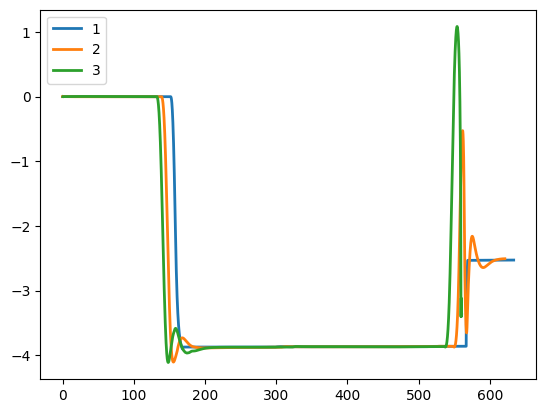

In [13]:
fig, ax = plt.subplots()
DX_=np.array(DX).T
DY_=np.array(DY).T
ax.plot(DX_, DY_, linewidth=2.0)

plt.legend(["1","2","3"], loc ="upper left")
plt.show()

In [14]:
min(DY[-1])-min(DY[0])

-0.20728540420532227

In [15]:
min(DY[0])

-3.9039406776428223

In [16]:
len(Theta.T[0])

8129

In [17]:
m=len(T)
m

8129

In [18]:
l=0
u=0
for i in range(0,m-1):
    if(T[i]>20 and T[i+1]<21):
        l=i
    if(T[i]>25 and T[i+1]<26):
        u=i
print(l,u)
    

2233 2777


In [19]:
arr=list(Theta.T[-1])
arr[l:u]

[-0.39140608369997704,
 -0.38593441950332746,
 -0.38026401691033074,
 -0.37473745830571203,
 -0.36857440420056425,
 -0.362873608281627,
 -0.35705956143733414,
 -0.3511548006684104,
 -0.3449592227084501,
 -0.33859380164996994,
 -0.3321228528332954,
 -0.32516670935552205,
 -0.3187836781443338,
 -0.31215457084842213,
 -0.30511806648475565,
 -0.2909899969018853,
 -0.2837019902627745,
 -0.2763516989436694,
 -0.2695308107597585,
 -0.2618604407671395,
 -0.2539982732417644,
 -0.24630969388519197,
 -0.2382701764759744,
 -0.23068283053033867,
 -0.22290799804396133,
 -0.21477628532675655,
 -0.20673298955774244,
 -0.19864653393431222,
 -0.1907710339587299,
 -0.18286893566176043,
 -0.17429295774046,
 -0.16570369730322282,
 -0.15709208295758575,
 -0.1483866920520643,
 -0.14083772891563934,
 -0.13222077160306533,
 -0.12423391820440408,
 -0.11606917396730392,
 -0.1080562215899599,
 -0.09960334829004838,
 -0.09138747968239712,
 -0.08383688535980446,
 -0.07665859263522648,
 -0.06786748539330731,
 -0.060

In [20]:
arr=Dyaw.T[-1]

In [21]:
arr[l:u][3]-arr[l:u][2]

0.0014802515128932922